In [22]:
%matplotlib notebook
import math
import json
import sys
import fileinput
import func
from operator import itemgetter
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot

#joint length
l1 = 160
l2 = 200
l3 = l1 + l2

# formula settings
d_max = 50
k_z = 20
k = .01
r = 10
eps = 2
qty = 30
r_2 = 2

In [23]:
def EnergyChange(a1, a2):
    angle_a_delta = a1[0] - a2[0]
    angle_b_delta = a1[1] - a2[1]
    angle_z_delta = a1[2] - a2[2]
    return (math.pow(angle_a_delta, 2) + math.pow(angle_b_delta, 2) +
            k_z * math.pow(angle_z_delta, 2))

def CartSpace(a1, a2):
    x_delta = a1[0] - a2[0]
    y_delta = a1[1] - a2[1]
    return (math.pow(x_delta, 2) + math.pow(y_delta, 2))

def Locality(a, r, space, trajectory):
    local_pnt = []
    xy = (a[0], a[1])
    for i in range(xy[0] - r, xy[0] + r):
        for j in range(xy[1] - r, xy[1] + r):
            ang_list = data[(i,j)]
            if (ang_list):
                for ang in ang_list:
                    if (ang[2] - a[2][2] < 90):
                        local_pnt.append((i, j, tuple(ang)))
    return (local_pnt)

def getMidpointC(p1, p2):
    mid_x = (p1[0] + p2[0]) / 2
    mid_y = (p1[1] + p2[1]) / 2
    return (mid_x, mid_y)


<IPython.core.display.Javascript object>


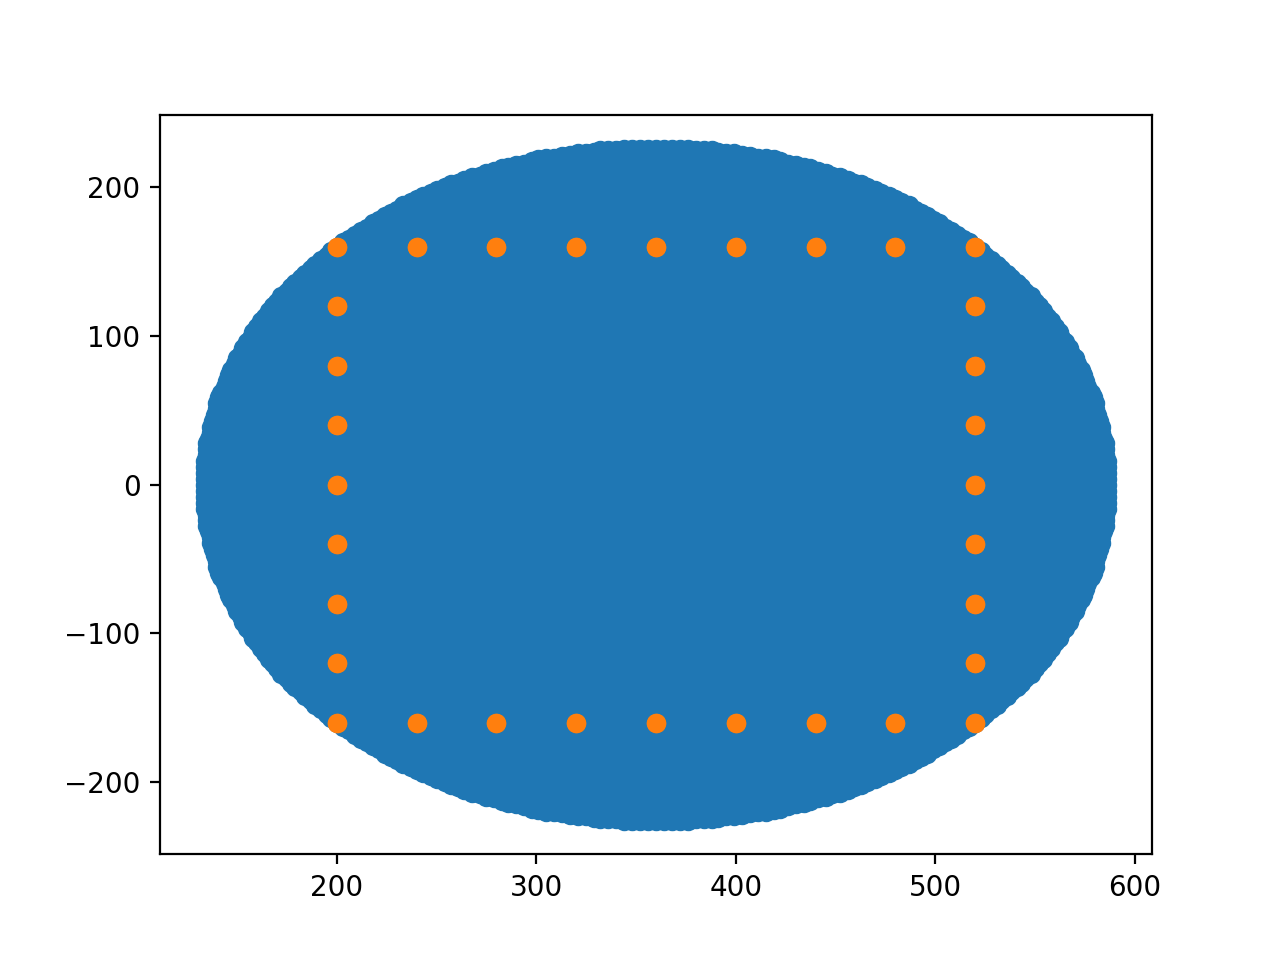

In [24]:
ifile = "points.txt"
ofile = "output.txt"

# load json data

data_pnts = None
with open('data_pnts.json', 'r') as fp:
    data_pnts = json.load(fp)

if not data_pnts:
    print ("Unable to load data file.")
    exit()

if data_pnts:
    data  = defaultdict(list)
    for i in data_pnts:
        for j in i["value"]:
            data[tuple(i["key"])].append(j)
            
points = []
for i in data:
    points.append(i)
x_p, y_p = zip(*points)

circ_fig = plt.figure()
circ_fig.canvas.set_window_title('Points from Data')
ax1 = circ_fig.add_subplot(111)
ax1.scatter(x_p, y_p)

# load (x,y) points
input_pnts = []
with open(ifile, 'r') as fInput:
    for line in fInput:
        vals = line.split(' ')
        x, y, p = vals
        input_pnts.append(((int(x), int(y)), int(p)))

if not input_pnts:
    print ("Unable to load input file.")
    exit()

x, y = func.getPosition((0, 0), l1, l2)
start_pnt = (int(x), int(y), (0, 0, 0), 0)
pnt_set = []

test_pnt = data[input_pnts[0][0]]
first_pnt = min(test_pnt, key=lambda ob: EnergyChange(start_pnt[2], ob))
#print(test_res)

x, y = input_pnts[0][0]
p = input_pnts[0][1]
pnt_set.append((x, y, first_pnt, p))

def getTrajectory(start, cartlist):
    ret_list = [start]
    if not cartlist:
        return ([])
    x, y = start[0], start[1]
    x_1, y_1 = cartlist[0][0]
    if (func.getDist((x,y), (x_1, y_1)) > d_max):
        new_cartlist = [tuple((getMidpointC((x,y), (x_1, y_1)), start[3]))] + cartlist
        return getTrajectory(start, new_cartlist)    
        #return getTrajectory(start, cartlist.insert(0, getMidpointC((x,y), (x_1, y_1))))
    ang = data[(x_1, y_1)]
    ang_res = None
    if not ang:
        min_list = []
        for i in range(x_1 - r_2, x_1 + r_2):
            for j in range(y_1 - r_2, y_1 + r_2):
                if (data[(i, j)]):
                    tmp = min(data[(i,j)], key=lambda ob: EnergyChange(start[2], ob))
                    min_list.append((i, j, tuple(tmp), start[3]))
        if not min_list:
            print ("nothing")
        ang_res = min(min_list, key=lambda ob: EnergyChange(start[2], ob[2]))
    else:
        tmp = min(ang, key=lambda ob: EnergyChange(start[2], ob))
        ang_res = (x_1, y_1, tuple(tmp))
    ret_list.append((x_1, y_1, ang_res[2], start[3]))
    return (ret_list + getTrajectory(ret_list[-1], cartlist[1:]))

pnt_set  = getTrajectory(pnt_set[-1], input_pnts[1:])

x_p, y_p, ang, p_val = zip(*pnt_set)
ax1.scatter(x_p, y_p)



<IPython.core.display.Javascript object>


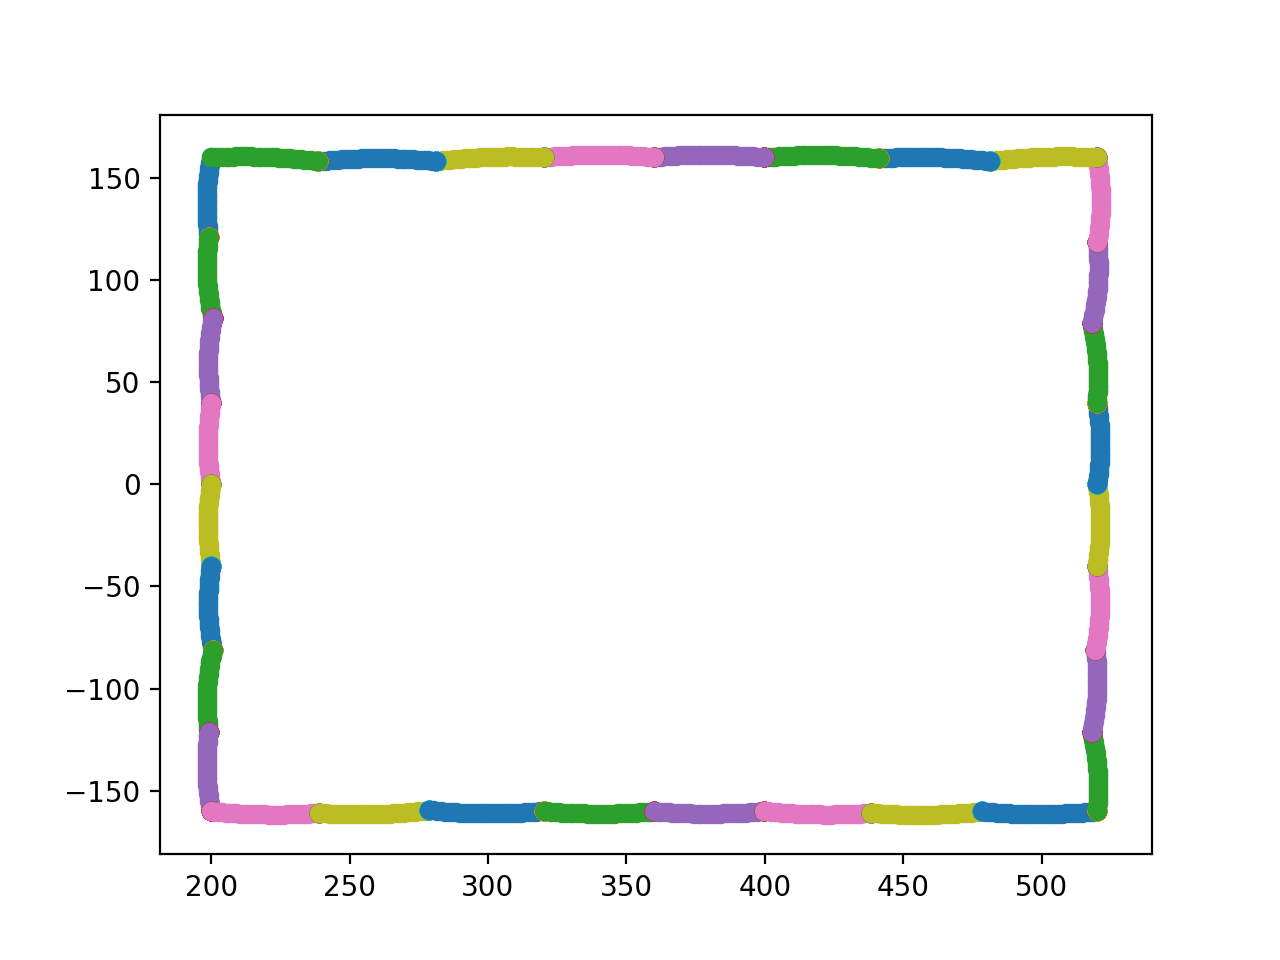

In [25]:
motion_fig = plt.figure()
motion_fig.canvas.set_window_title('Motion')
ax3 = motion_fig.add_subplot(111)
x_p, y_p = zip(*points)
#ax3.scatter(x_p, y_p)

def calc(l_1, l_2, x, y, z):
    x_s, y_s = func.getPosition((x, y), l_1, l_2)
    res_x, res_y = func.getTransform((x_s, y_s), (l_1 + l_2, 0), z)
    return (res_x, res_y)

def getInter(p1, p2):
    x_ret, y_ret = [], []
    
    x_1, y_1, z_1 = p1
    x_2, y_2, z_2 = p2
    
    xt_inc = -(x_1 - x_2) / float(qty)
    yt_inc = -(y_1 - y_2) / float(qty)
    zt_inc = -(z_1 - z_2) / float(qty)
    for i in range(qty + 1):
        x, y = calc(l1, l2, x_1 + xt_inc * i, y_1 + yt_inc * i, z_1 + zt_inc * i)
        x_ret.append(x)
        y_ret.append(y)
    return (x_ret, y_ret)
        
x_p, y_p = [], []
for i in range(len(pnt_set) - 1):
    if (i < len(pnt_set)):
        A = pnt_set[i]
        B = pnt_set[i + 1]
        x, y = getInter(A[2], B[2])
        ax3.scatter(x, y)


In [29]:
with open(ofile, 'w') as fOutput:
    for i in pnt_set:
        x = i[2][1] + i[2][0]
        y = i[2][0]
        z = i[2][2]
        fOutput.write("G0 X%d Y%d Z%d\n" % (x, y, z))